In [1]:
# import...
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import sys
from scipy.signal import find_peaks
import pandas as pd

os.chdir("/Users/etmu9498/research/code/scripts")
import make_plots
os.chdir("/Users/etmu9498/research/code/scripts-winter2023")
import helper_fns_winter2023 as helper_fns
sys.path.append(  "/Users/etmu9498/research/code/scripts-winter2023/cloud-top-height-stats")
import eyewall_metadata
import find_cloud_tops

In [2]:
# helper function for loading data! To make the figures below, the dictionary loading code option is used    
def load_data_helper(tc):
    crl_data_root = "/Users/etmu9498/research/data/crl-all-data-processed/"

    # case 1: do this for all crl datasets (2021 and 2022)
    if tc == 'all':
        # make a list of years where crl data is present
        yearlist = ['2021', '2022']
        # make a list of lists of all the datasets to be processed ( each year has a sublist)
        filelist = []
        filelist.append( make_plots.load_flight_level( crl_data_root + '2021', print_files=False) )
        filelist.append( make_plots.load_flight_level( crl_data_root + '2022', print_files=False) )
    # case 2: do this for just one year
    elif tc == '2021':
        yearlist = ['2021']
        filelist = [ make_plots.load_flight_level( crl_data_root + '2021', print_files=False)]
    elif tc == '2022':
        yearlist = ['2022']
        filelist = [ make_plots.load_flight_level( crl_data_root + '2022', print_files=False)]
    # case 3: do this for a specific dictionary of files:
    elif type( tc) == type( {}):
        # make the folder_list: just the dates saved in the dictionary!
        yearlist = list( tc.keys())
        filelist = []
        for keyi, keyval in enumerate( yearlist):
            filelist.append( tc[ keyval])
    else:
        print( "Error: please enter a valid selection for tc")

    return yearlist, filelist

In [3]:
# return high and low confidence limits (and the mean) for a specified time series
# and confidence interval. Use t statistics to do so! Good for small (N<30) samples.
def t_test_intervals( data, confidence=.95, nstar=False):
    diff = 1 - confidence
    tableval = confidence + diff / 2
    data_inds = np.where( ~ np.isnan( data)) [0]
    data = np.array( data) [data_inds]

    if nstar:
        df = nstar
    else:
        N = len( data)
        df=N-1

    mean = data.mean()
    std = data.std()
    # find the t test upper and lower limits
    tstat = scipy.stats.t.ppf( tableval, df)
    low_limitt = mean - tstat * ( std / np.sqrt( N-1))
    high_limitt = mean + tstat * ( std / np.sqrt( N-1))
    return mean, low_limitt, high_limitt

In [4]:
# a simple helper fn that just bins up all the heights! and returns them in a list of lists
# has the same bin width / bins as the weighting_fn below
def binning_fn(height, binwidth):
    # remove 0 km heights from figure!
    height = height[np.where(height > 50)[0]]
    height_bin = np.arange(0, 4510, binwidth)

    # save heights for each bin here
    heightlist = []
    
    # do this for every height level determined by the manually inputed bin width
    for newi in height_bin:
        # find the points that fall within this height bin for this step
        res = height[ np.where(np.logical_and( height >= newi - binwidth / 2., height <= newi + binwidth / 2. ))[0]]
        heightlist.append( res.tolist())
        
    return height_bin, heightlist
        


# helper function for making a weighted histogram!
def weighting_fn( height, binwidth, smoothwidth):
    
    # remove 0 km heights from figure!
    plot_height = height[ np.where( height > 50)[0] ]
    height_bin=np.arange(0, 4510, binwidth)

    print( "Non clear air %. Should match sum afte analysis: " + str(( len(plot_height)/len(height)) * 100 ))
    
    # calculate mean height variation within the bin range
    mean_height=[]
    mean_height_count=[]
    mean_height_prob = []
    # do this for every height level determined by the manually inputed bin width
    for newi in height_bin:
        # find the points that fall within this height bin for this step
        res=np.where(np.logical_and( plot_height >= newi - binwidth / 2., plot_height <= newi + binwidth / 2. ))
        mean_height.append( np.mean( plot_height[ res]))
        mean_height_count.append( len( res[0]))
        # use height, not plot_height, to include heights below 50m in caclulations
        # this line accounts for clear air fraction when scaling the curves!
        if len( height) > 0:
            mean_height_prob.append( len( res[0] ) / len( height))
        else:
            mean_height_prob.append( len( res[0] ) / .00001 )
    
    # smooth data before plotting to eliminate noise

    # old method: breaks when the binwidth and smoothwidths are too high. The new code below functions
    # similarly / same results (which is good, phew!), but it doesn't break like before.
    # box = np.ones( smoothwidth) / smoothwidth
    # prob_smooth = np.convolve( mean_height_prob, box, mode='same')
    
    # new method (as of 4/1/23): use pandas.rolling() to smooth the data
    # still takes a bit of forethought when inputing 
    prob_smooth = np.array(pd.Series(mean_height_prob).rolling(window=smoothwidth, min_periods=1, center=True).mean())
    
    # print( len( prob_smooth))
    # print( prob_smooth)
    
    return prob_smooth * 100, height_bin


In [5]:
# similar to the code above, but don't include the lidar data plots, and plot all
# histograms for a day atop one another
def plot_one_day( tc='all'):
    # use a helper function to figure out which years / files to plot
    yearlist, filelist = load_data_helper( tc)
    # print out the number of files to be saved
    filecount = 0
    for yeari in range( len( filelist)):
        # count all the names in this year, and add to the count
        filecount += len( filelist[ yeari])
    print("Number of data files to be plotted: " + str( filecount))

    # constants / recursive variables used below
    lw = 2 # plot linewidths
    crl_data_root = "/Users/etmu9498/research/data/crl-all-data-processed/" # location of data
    binwidth = 25 # width (in m) of each cloud height bin
    smoothwidth = 25 # number of points around current data point to smooth over!
    
    metadata = eyewall_metadata.all_metadata() # manually determined eyewall limits
    colors = [ 'darkgreen', 'seagreen', 'springgreen', 'mediumturquoise', 'darkcyan'] # plot colors

    # kinda annoying format, but these are the precise colors used for each case in previous analyses!
    colors2=[ [0.1, 0.58778525, 0.95105652, 1.], [0.7, 0.95105652, 0.58778525, 1.], 
                    [1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00]]
    # colors2 = ['b', 'g', 'Grey']
    
    # create an average dist figure here for all data from one date
    fig2, ax2 = plt.subplots(1, 1, figsize=(8, 4))
    helper_fns.change_font_sizes( 18, 18)
    # add some nice labels, scales, etc
    ax2.set_ylabel("Height (m)")
    ax2.set_xlabel("Cloud Height Probability (%)")
    ax2.set_title( "Average Daily Cloud Height Probabilities for TC Sam")
    
    # do this for all selected datasets! years and filenames
    for yeari, yearval in enumerate( yearlist):
        for filei, fileval in enumerate( filelist[ yeari]):

            # recursively save height data for one full day here!
            # useful for making a total plot later
            dailyheights = []
            
            # recursively save cloud top probabilities here!
            daily_probs = []
            
            # check if eyewall limits exist for the date given below... if not, give it some empty eyewall limits!
            # also check for fred am and pm cases! Those cause errors.
            date = fileval[7:11]
            if date == '0812':
                if fileval[11:13] == "H1":
                    eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812am']
                elif fileval[11:13] == "H2":
                    eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812pm']
            elif date in metadata[ yearval]['eyewall_limits'].keys():
                eyewall_limits = metadata[ yearval]['eyewall_limits'][ date]
            else:
                eyewall_limits = [ ()]

            # make plots for proposed eyewall limits!
            
            # create a new many subplot figure and add histogram data
            fig, ax = plt.subplots(1, 1, figsize=(12, 6))
            # helper_fns.change_font_sizes( 12, 12)
            # add some nice labels, scales, etc
            ax.set_ylabel("Height (m)")
            ax.set_xlabel("Cloud Height Probability (%)")
            ax.set_title( "Cloud Height Probabilities for " + fileval)

            # do this for each eyewall limit pair
            for pairi, pairval in enumerate( eyewall_limits):
                print( "Eyewall limits: " + str( pairval))
                # only do this if there are eyewall limits to look at
                if len( pairval) > 1:
                    lefteyewall = pairval[ 0]
                    righteyewall = pairval[ 1]
                # otherwise, give the eyewalls some arbitrary values and don't trim the eyewalls
                else:
                    lefteyewall = -100
                    righteyewall = -50
                
                # load crl data and get cloud heights
                crl_path = crl_data_root + yearval
                os.chdir( crl_path)
                crl_data = xr.open_dataset( fileval)
                time = crl_data.time
                height = crl_data.height
                if yearval == '2021':
                    min = -30
                elif yearval == '2022':
                    min = -40
                # preparation: find cloud heights for this eye pass
                li = np.argmin( np.abs(crl_data.time.values - lefteyewall))
                ri = np.argmin( np.abs(crl_data.time.values - righteyewall))
                H = crl_data.height
                power = crl_data.P_ch1[ li:ri, :]
                axis = crl_data.time[ li:ri]
                p3_height = crl_data.p3_height[ li:ri]
                cloudheights, cloudtime = find_cloud_tops.find_cloud_heights( H, power, axis, p3_height, cutoff_power = min)

                # add the current cloud heights to the daily cloud heights total
                dailyheights += cloudheights.tolist()
                
                
                # print out what the binned cloud heights look like! just to get a sense of the data coverage
                heightbin, cloudheightsbinned =binning_fn( np.array(cloudheights), binwidth)
                print( len(heightbin))
                print( len(cloudheightsbinned))
                
                # first, bin and smooth the cloud heights
                prob_smooth, height_bin = weighting_fn( np.array( cloudheights), binwidth, smoothwidth)
                
                daily_probs.append( prob_smooth)
                
                '''
                print( len( height_bin))
                print( len( prob_smooth))
                print( height_bin)
                print( prob_smooth)
                probsum = 0
                for val in prob_smooth:
                    probsum += val
                print( probsum)
                print("\n\n\n")
                '''
                
                # add a new line plot with raw histogram data!
                ax.plot( prob_smooth, height_bin, color=colors[pairi], linewidth=lw, label='case ' + str( pairi))

            print( "number of cloud data points for this run = " + str(len(dailyheights)))

            ax.legend( loc='lower right')

            # save the daily plot on the total figure created above!
            prob_smooth, height_bin = weighting_fn( np.array( dailyheights), binwidth, smoothwidth)
            ax2.plot( prob_smooth, height_bin, color=colors2[filei], linewidth=lw, label=date[0:2] + "/" + date[2:4])
            
    ax2.legend(loc='lower right')
    ax2.set_ylim(0,3200)
    
    # made it outside of year / day loops: save the last remaining averaged and many height plots now
    # saving the multiple distribution figure for the previous date
    savedir = "/Users/etmu9498/research-private/colloquium/"
    os.chdir( savedir)
    fig2.savefig( "crl-total-heights.png", dpi=250, bbox_inches='tight')
    print( "Figure " + date + " Saved")

    print( "Figure " + fileval + ", case " + str( pairi) + " Saved")

Number of data files to be plotted: 3
Eyewall limits: (22.58, 22.6826)
181
181
Non clear air %. Should match sum afte analysis: 100.0
Eyewall limits: (23.8448, 23.8937)
181
181
Non clear air %. Should match sum afte analysis: 100.0
Eyewall limits: (24.8804, 24.9521)


C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


181
181
Non clear air %. Should match sum afte analysis: 82.94573643410853
number of cloud data points for this run = 401
Non clear air %. Should match sum afte analysis: 94.51371571072319
Eyewall limits: (23.3316, 23.3971)
181
181
Non clear air %. Should match sum afte analysis: 82.20338983050848


C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Eyewall limits: (24.5296, 24.5724)
181
181
Non clear air %. Should match sum afte analysis: 85.71428571428571
number of cloud data points for this run = 195
Non clear air %. Should match sum afte analysis: 83.58974358974359
Eyewall limits: (21.5788, 21.6793)


C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


181
181
Non clear air %. Should match sum afte analysis: 93.92265193370166
Eyewall limits: (22.7988, 22.8877)
181
181
Non clear air %. Should match sum afte analysis: 100.0
number of cloud data points for this run = 341
Non clear air %. Should match sum afte analysis: 96.7741935483871


C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\etmu9498\Anaconda3\envs\tcresearch\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Figure 0929 Saved
Figure P3_20210929H2_processed.nc, case 1 Saved


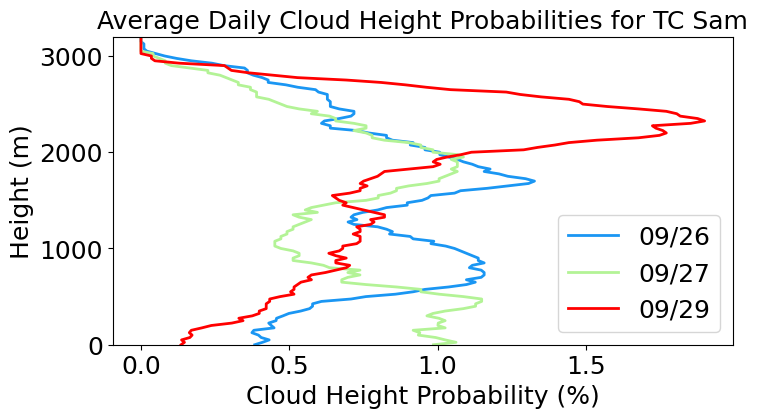

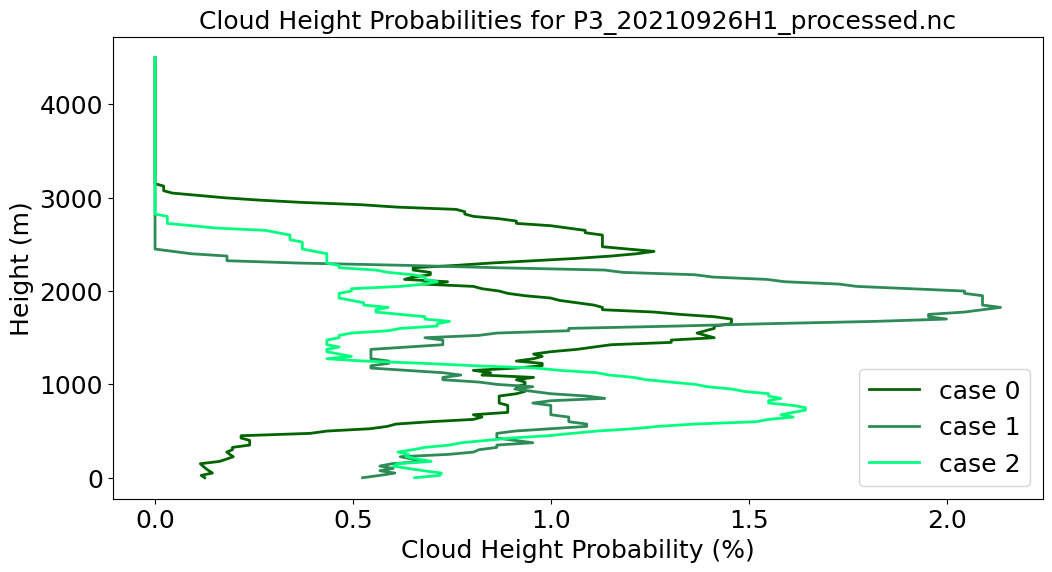

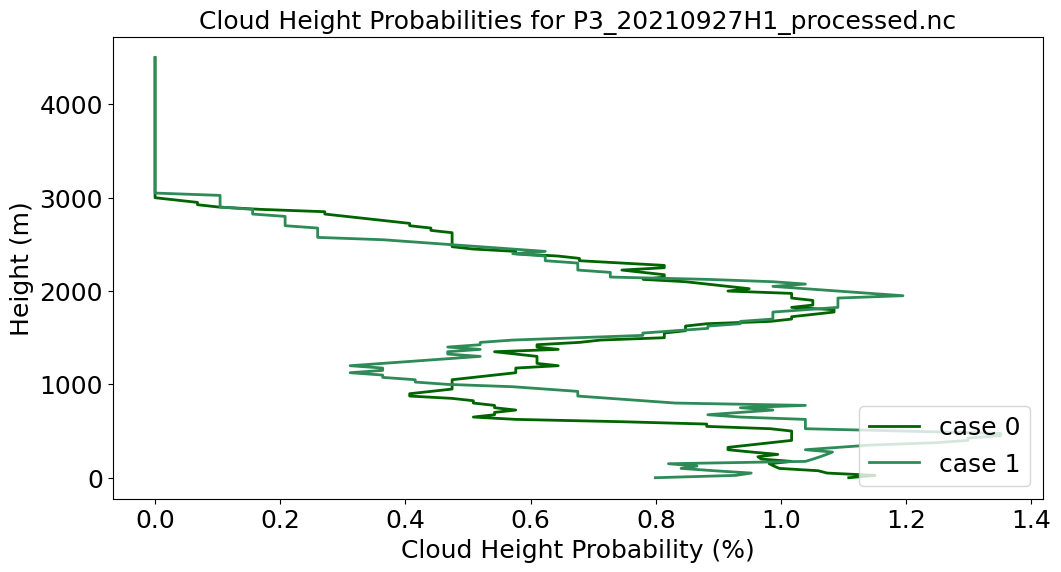

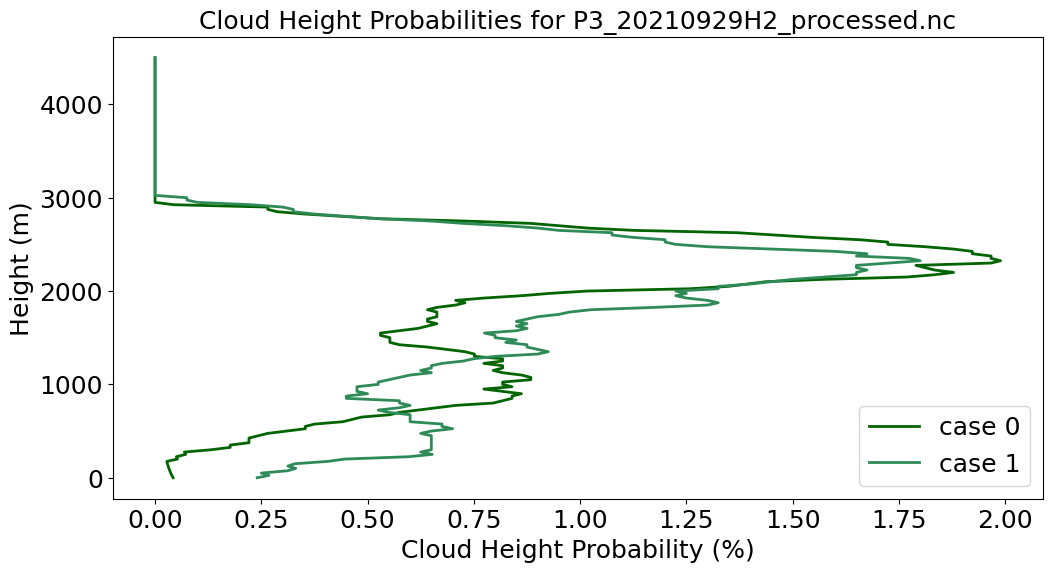

In [7]:
inputdict = {}
inputdict['2021'] = ['P3_20210926H1_processed.nc', 'P3_20210927H1_processed.nc', 'P3_20210929H2_processed.nc']
plot_one_day( tc=inputdict)